In [177]:
import numpy.random as sim
import numpy as np
def arrondi(x):
    return int(x)+ (int(x*10)%10)/10
data = np.array([arrondi(-10+2*sim.randn()) for i in range(100000)], dtype = np.float64)
data

array([ -7.2,  -5.7,  -5.5, ...,  -9.3, -11.7,  -9.3])

In [178]:
def get_freq(data):
    sorted_data = sorted(data)
    freq = []
    x = []
    n = len(sorted_data)
    for i in range(len(sorted_data)):
        if i == 0:
            freq.append(1/n)
            x.append(sorted_data[i])
        elif sorted_data[i-1]!=sorted_data[i]:
            freq.append(freq[-1]+1/n)
            x.append(sorted_data[i])
        else:
            freq[-1] += 1/n
    return freq, x

In [201]:
import numba as nb
@nb.njit
def count_sort(data):
    pos = data[data >= 0]
    neg = data[data <= 0]
    if len(pos) == 0:
        len_pos = 0
    else:
        len_pos = max(pos)+1
    if len(neg) == 0:
        len_neg = 0
    else:
        len_neg = abs(min(neg))+1
    postive_values = np.zeros(len_pos, dtype=np.int64)
    negative_values = np.zeros(len_neg, dtype = np.int64)
    sorted_list = np.zeros(len(data), dtype=np.int64)
    for i in range(len(data)):
        if (data[i] >= 0) :
            postive_values[data[i]] += 1
        else:
            negative_values[abs(data[i])] += 1
    last_index = 0
    for i in range(len(negative_values)):
        for j in range(negative_values[len(negative_values) - i - 1]):
            sorted_list[last_index] = -(len(negative_values) - i -1)
            last_index += 1
    for i in range(len(postive_values)):
        for j in range(postive_values[i]):
            sorted_list[last_index] = i
            last_index += 1
    return sorted_list

In [220]:
A = np.random.randint(-100,100,size=10000)
A

array([ 42, -64, -49, ...,   2, -22, -86])

In [221]:
np.unique(A)

array([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,
        -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,  -79,
        -78,  -77,  -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,  -68,
        -67,  -66,  -65,  -64,  -63,  -62,  -61,  -60,  -59,  -58,  -57,
        -56,  -55,  -54,  -53,  -52,  -51,  -50,  -49,  -48,  -47,  -46,
        -45,  -44,  -43,  -42,  -41,  -40,  -39,  -38,  -37,  -36,  -35,
        -34,  -33,  -32,  -31,  -30,  -29,  -28,  -27,  -26,  -25,  -24,
        -23,  -22,  -21,  -20,  -19,  -18,  -17,  -16,  -15,  -14,  -13,
        -12,  -11,  -10,   -9,   -8,   -7,   -6,   -5,   -4,   -3,   -2,
         -1,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
         21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
         32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48,   49,   

In [243]:
@nb.njit
def VaR2(data, alpha, l):
    sorted_data = count_sort(data)
    freq = np.zeros(l, dtype = np.float64)
    x = np.zeros(l, dtype = np.int64)
    n = len(sorted_data)
    last_visited = 0
    for i in range(n):
        if i == 0:
            freq[last_visited] = 1/n
            x[last_visited] = sorted_data[i]
            if (freq[last_visited] >= 1-alpha) :
                return -sorted_data[i]
        elif sorted_data[i-1]!=sorted_data[i]:
            last_visited += 1
            freq[last_visited] = freq[last_visited-1]+1/n
            x[last_visited] = sorted_data[i]
            if (freq[last_visited] >= 1-alpha) :
                return -sorted_data[i]
            
        else:
            freq[last_visited] += 1/n
            if (freq[last_visited] >= 1-alpha) :
                return -sorted_data[i]

In [234]:
def VaR(data, alpha):
    freq, x = get_freq(data)
    for i in range(len(freq)):
        if (freq[i] >= 1-alpha) :
            return -x[i]

In [235]:
A = np.array(10*data, dtype=np.int64)

In [236]:
l = len(set(A))

In [261]:
VaR(A, 0.2)

74

In [262]:
VaR2(A,0.2,l)

74

In [266]:
def tVaR(data, alpha, precision):
    alphas = np.linspace(alpha,1-(1-alpha)/precision, precision)
    sum_VaR = 0
    for alpha_i in alphas:
        sum_VaR += VaR(data, alpha_i)
    
    sum_VaR = sum_VaR / precision

    return sum_VaR

In [265]:
@nb.njit
def tVaR2(data, alpha, precision, l):
    alphas = np.linspace(alpha,1-(1-alpha)/precision, precision)
    sum_VaR = 0
    for alpha_i in alphas:
        sum_VaR += VaR2(data, alpha_i, l)
    
    sum_VaR = sum_VaR / precision

    return sum_VaR

In [270]:
%timeit tVaR(A,0.99,100)

4.99 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [271]:
%timeit tVaR2(A,0.99,100, l)

44.1 ms ± 930 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

Accord = pd.read_excel('AccordHotel.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
Axa = pd.read_excel('Axa.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
BNP = pd.read_excel('BNP.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
Casino = pd.read_excel('Casino.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
ENGI = pd.read_excel('ENGI.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
LVMH = pd.read_excel('LVMH.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
Orange = pd.read_excel('Orange.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
Peugeot = pd.read_excel('Peugeot.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
Renault = pd.read_excel('Renault.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
Total = pd.read_excel('Total.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
Veolia = pd.read_excel('Veolia.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])
Vivendi = pd.read_excel('Vivendi.xlsm', names = ['id', 'date', 'open', 'high', 'low', 'close', 'volume'])

datas = [Accord, Axa, BNP, Casino, ENGI, LVMH, Orange, Peugeot, Renault, Total, Veolia, Vivendi]

In [273]:
for i in range(len(datas)):
    datas[i]['R'] = np.nan
    for j in range(254):
        datas[i]['R'].iloc[j] = (datas[i]['low'].iloc[j+1] + datas[i]['high'].iloc[j+1])/(datas[i]['low'].iloc[j] + datas[i]['high'].iloc[j]) - 1

ER = [np.mean(datas[i]['R']) for i in range(len(datas))]
ER


C:\Users\user\AppData\Local\Temp\ipykernel_11608\44500515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas[i]['R'].iloc[j] = (datas[i]['low'].iloc[j+1] + datas[i]['high'].iloc[j+1])/(datas[i]['low'].iloc[j] + datas[i]['high'].iloc[j]) - 1
C:\Users\user\AppData\Local\Temp\ipykernel_11608\44500515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas[i]['R'].iloc[j] = (datas[i]['low'].iloc[j+1] + datas[i]['high'].iloc[j+1])/(datas[i]['low'].iloc[j] + datas[i]['high'].iloc[j]) - 1
C:\Users\user\AppData\Local\Temp\ipykernel_11608\44500515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

[-0.0006401792778455088,
 -0.0010525263114721855,
 -0.001829743349972335,
 -0.0013104455101185235,
 -0.000492563944316347,
 0.00025878178177848724,
 -8.334380139173682e-05,
 0.00035640289946057446,
 -0.0017154854383169872,
 7.791569222361497e-06,
 -0.0006615667317761678,
 -0.00024007184962658568]

In [280]:
modified_datas = []
for i in range(len(datas)):
    modified_datas.append((10000*(datas[i]['R'].dropna())).apply(int).to_numpy())
modified_datas = np.array(modified_datas)

In [287]:
def VaR2_(data, alpha):
    sorted_data = sorted(data)
    freq = []
    x = []
    n = len(sorted_data)
    for i in range(len(sorted_data)):
        if i == 0:
            freq.append(1/n)
            x.append(sorted_data[i])
            if (freq[-1] >= 1-alpha) :
                return -sorted_data[i]
        elif sorted_data[i-1]!=sorted_data[i]:
            freq.append(freq[-1]+1/n)
            x.append(sorted_data[i])
            if (freq[-1] >= 1-alpha) :
                return -sorted_data[i]
        else:
            freq[-1] += 1/n
            if (freq[-1] >= 1-alpha) :
                return -sorted_data[i]
    return freq, x

In [289]:
winners = {}
for i in range(100000):
    opt_VaR = np.Inf
    ER_x = np.zeros(12)
    x = np.zeros(12)
    datas_x = np.zeros(len(datas[0]['R']))
    for j in range(11):
        x[j] = 2*np.random.randn()
        ER_x[j] = x[j]*ER[j]
        datas_x += (datas[j]['R']*x[j]).to_numpy()
    x[11] = 1 - np.sum(x)
    ER_x[11] = x[11]*ER[11]
    datas_x += (datas[11]['R']*x[11]).to_numpy()
    ER_x_val = ER_x.sum()
    VaR_x = VaR2_(datas_x.tolist(), 0.95)
    #if (ER_x_val >= (1.05**(1/255)) - 1):
    if (VaR_x < opt_VaR):
        opt_x = x
        opt_ER = ER_x_val
        opt_VaR = VaR_x
    winners[str(x.tolist())] = {'VaR': VaR_x, 'ER': ER_x_val}
print(opt_x, ' - ', opt_ER, ' - ', opt_VaR)


[ 1.5371921   2.84563712 -1.15700072  5.2037635  -0.32896454 -1.2860369
  1.1763415  -2.22367333 -0.66916914 -2.15065196 -0.14823329 -1.79920434]  -  -0.0080815543636139  -  0.13941023841748892


In [290]:
X = []
Y = []
for key in winners:
    X.append(winners[key]['VaR'])
    Y.append(winners[key]['ER'])

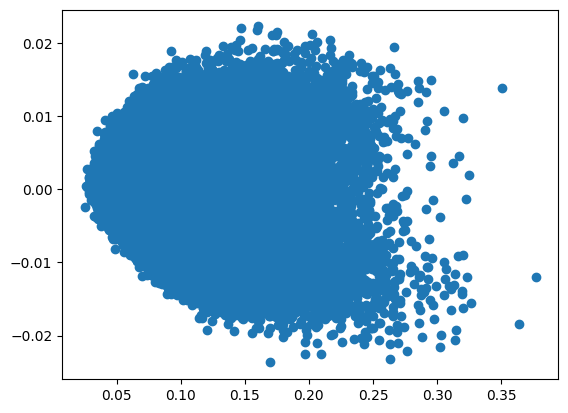

In [291]:
plt.scatter(X,Y)

In [298]:
winners = {}
for i in range(10000000):
    opt_VaR = np.Inf
    ER_x = np.zeros(12)
    x = np.zeros(12)
    datas_x = np.zeros(len(modified_datas[0]))
    for j in range(11):
        x[j] = 2*np.random.randn()
        ER_x[j] = x[j]*ER[j]
        datas_x += modified_datas[j]*x[j]
    x[11] = 1 - np.sum(x)
    ER_x[11] = x[11]*ER[11]
    datas_x += modified_datas[11]*x[11]
    datas_x = np.array(datas_x, dtype = np.int64)
    ER_x_val = ER_x.sum()
    l = len(set(datas_x))
    VaR_x = VaR2(datas_x, 0.95, l)/10000
    #if (ER_x_val >= (1.05**(1/255)) - 1):
    if (VaR_x < opt_VaR):
        opt_x = x
        opt_ER = ER_x_val
        opt_VaR = VaR_x
    winners[str(x.tolist())] = {'VaR': VaR_x, 'ER': ER_x_val}
print(opt_x, ' - ', opt_ER, ' - ', opt_VaR)

[ 0.85147702  0.5632675   4.16695933 -3.25863392 -0.41698024 -1.69253147
  0.54722928 -0.38831587  1.07498674 -1.04570667  2.50732821 -1.90907991]  -  -0.00796148808283984  -  0.1213


In [299]:
X = []
Y = []
for key in winners:
    X.append(winners[key]['VaR'])
    Y.append(winners[key]['ER'])

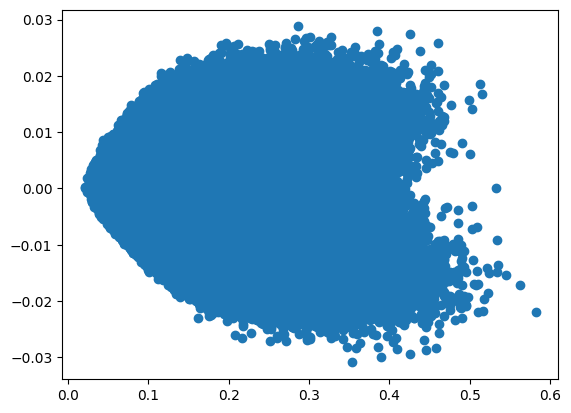

In [300]:
plt.scatter(X,Y)

In [301]:
min_val_VaR = np.Inf

for key in winners:
    if (winners[key]['ER'] >= (1.05**(1/255) - 1)):
        if (winners[key]['VaR'] < min_val_VaR):
            min_val_VaR = winners[key]['VaR']
            x_opt_ = key
            ER_opt_ = winners[key]['ER']

print(x_opt_, " - ", ER_opt_, " - ", min_val_VaR)

[0.0904976273171428, -0.03438195507925349, 0.3155246165604377, -0.08943814572808659, -0.6819344767906492, -0.160253191605498, 0.4797462371902408, 0.4875986553027999, -0.20108705343175368, 0.8188881840258719, 0.259811468539117, -0.28497196630036914]  -  0.00019422484175245854  -  0.021
